In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

tf.compat.v1.get_default_graph()
tf.compat.v1.train.Optimizer
# Load your weather dataset
data = pd.read_csv('modified_file.csv')  # Replace 'your_dataset.csv' with the actual file name
data.fillna(0, inplace=True)

In [2]:
# Convert 'DATE' column to numerical format (day of the year)
data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%Y')
data['DATE'] = data['DATE'].dt.dayofyear

# Drop non-numeric columns for simplicity
non_numeric_columns = ['STATION', 'NAME']
df_weather_numeric = data.drop(columns=non_numeric_columns)

In [3]:
# Use the same features for training and testing
features = df_weather_numeric.columns
# Data splitting
x_train_weather, x_test_weather, y_train_continuous, y_test_continuous = train_test_split(
    df_weather_numeric, data['TAVG'], test_size=0.2, random_state=0
)

# Standardize the data
scaler_weather = StandardScaler()
scaler_weather.fit(x_train_weather)
x_train_weather = scaler_weather.fit_transform(x_train_weather)
x_test_weather = scaler_weather.transform(x_test_weather)

In [4]:
# Save the scaler
import joblib
joblib.dump(scaler_weather, 'scaler_weather.joblib')

['scaler_weather.joblib']

In [5]:
# Convert the data into sequences for time series forecasting
def create_sequences(data, target_column, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = target_column[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

In [6]:
# Use the same features for training and testing
features = df_weather_numeric.columns
# Data splitting
x_train_weather, x_test_weather, y_train_continuous, y_test_continuous = train_test_split(
    df_weather_numeric, data['TAVG'], test_size=0.2, random_state=0
)

# Standardize the data
scaler_weather = StandardScaler()
scaler_weather.fit(x_train_weather)
x_train_weather = scaler_weather.fit_transform(x_train_weather)
x_test_weather = scaler_weather.transform(x_test_weather)

In [7]:
sequence_length = 10  # You can adjust this based on your requirements
X_train_seq, y_train_seq = create_sequences(x_train_weather, y_train_continuous.values, sequence_length)
X_test_seq, y_test_seq = create_sequences(x_test_weather, y_test_continuous.values, sequence_length)

In [8]:
# Build the LSTM model for time series forecasting
model_time_series = Sequential()
model_time_series.add(LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_time_series.add(Dropout(0.5))
model_time_series.add(Dense(1, activation='linear'))

model_time_series.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [9]:
model_time_series.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.2)

# Save the trained model (optional)
model_time_series.save('temperature_time_series_model.h5')

Epoch 1/100
174/174 [==============================] - 1s 3ms/step - loss: 1451.6913 - mean_absolute_error: 30.2761 - val_loss: 1153.2913 - val_mean_absolute_error: 18.1115
Epoch 2/100
174/174 [==============================] - 0s 2ms/step - loss: 518.2255 - mean_absolute_error: 18.4563 - val_loss: 562.4144 - val_mean_absolute_error: 16.6025
Epoch 3/100
174/174 [==============================] - 0s 2ms/step - loss: 459.9081 - mean_absolute_error: 17.5109 - val_loss: 393.5037 - val_mean_absolute_error: 15.0746
Epoch 4/100
174/174 [==============================] - 0s 2ms/step - loss: 450.1553 - mean_absolute_error: 17.3216 - val_loss: 399.5640 - val_mean_absolute_error: 15.9591
Epoch 5/100
174/174 [==============================] - 0s 2ms/step - loss: 421.9005 - mean_absolute_error: 16.9136 - val_loss: 344.9018 - val_mean_absolute_error: 14.7253
Epoch 6/100
174/174 [==============================] - 0s 2ms/step - loss: 417.1735 - mean_absolute_error: 16.7219 - val_loss: 324.9012 - val_m

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Generate future dates for prediction
last_date = datetime.strptime('24-10-2023', '%d-%m-%Y')
num_future_days = 430  # Adjust as needed
future_dates = [last_date + timedelta(days=i) for i in range(1, num_future_days + 1)]

# Create a DataFrame with future dates and fill other columns with zeros
future_data = pd.DataFrame({'DATE': future_dates})
for column in df_weather_numeric.columns:
    if column != 'DATE':
        future_data[column] = 0

# Convert 'DATE' column to numerical format (day of the year)
future_data['DATE'] = pd.to_datetime(future_data['DATE']).dt.dayofyear

In [11]:
# Ensure feature names match between training data and future data
scaler_weather = joblib.load('scaler_weather.joblib')
future_data_standardized = scaler_weather.transform(future_data[features])
future_data_seq, _ = create_sequences(future_data_standardized, y_train_continuous.values, sequence_length)

# Make predictions for time series forecasting
future_y_pred_time_series = model_time_series.predict(future_data_seq)

future_dates = [last_date + timedelta(days=i) for i in range(1, len(future_y_pred_time_series) + 1)]


14/14 [==============================] - 0s 959us/step


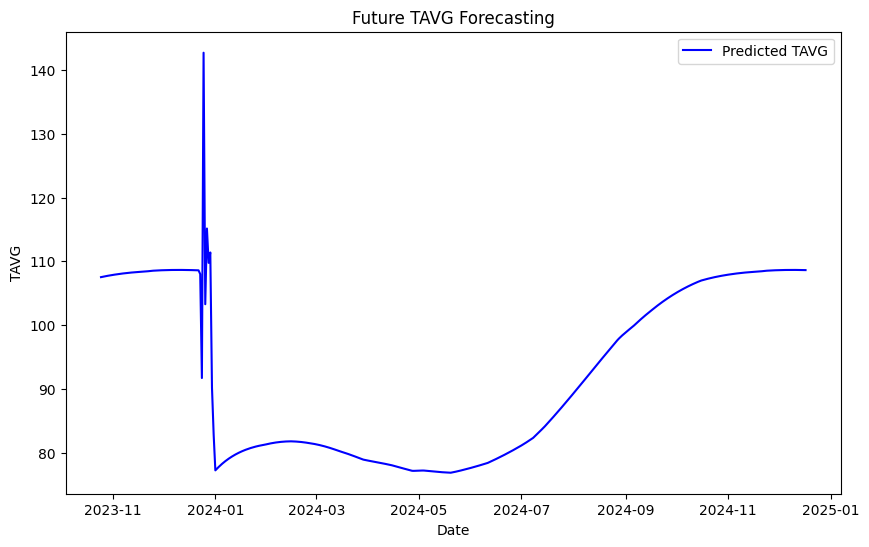

2023-10-25 00:00:00  :  [107.52981]
2023-10-26 00:00:00  :  [107.58557]
2023-10-27 00:00:00  :  [107.63905]
2023-10-28 00:00:00  :  [107.69041]
2023-10-29 00:00:00  :  [107.739624]
2023-10-30 00:00:00  :  [107.78687]
2023-10-31 00:00:00  :  [107.83206]
2023-11-01 00:00:00  :  [107.8753]
2023-11-02 00:00:00  :  [107.91663]
2023-11-03 00:00:00  :  [107.95656]
2023-11-04 00:00:00  :  [107.99549]
2023-11-05 00:00:00  :  [108.03279]
2023-11-06 00:00:00  :  [108.06841]
2023-11-07 00:00:00  :  [108.10222]
2023-11-08 00:00:00  :  [108.13433]
2023-11-09 00:00:00  :  [108.16478]
2023-11-10 00:00:00  :  [108.19359]
2023-11-11 00:00:00  :  [108.220955]
2023-11-12 00:00:00  :  [108.24662]
2023-11-13 00:00:00  :  [108.270805]
2023-11-14 00:00:00  :  [108.29349]
2023-11-15 00:00:00  :  [108.31473]
2023-11-16 00:00:00  :  [108.33463]
2023-11-17 00:00:00  :  [108.353096]
2023-11-18 00:00:00  :  [108.37019]
2023-11-19 00:00:00  :  [108.38603]
2023-11-20 00:00:00  :  [108.400475]
2023-11-21 00:00:00  :  

In [12]:
# Plot for Time Series Forecasting
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_y_pred_time_series, label='Predicted TAVG', color='blue')
plt.title('Future TAVG Forecasting')
plt.xlabel('Date')
plt.ylabel('TAVG')
plt.legend()
plt.show()
for i in range(len(future_dates)):
    print(future_dates[i], " : ",future_y_pred_time_series[i])